<a href="https://colab.research.google.com/github/ejrtks1020/Kaggle_Computer_Vision/blob/main/Kaggle_Steel_Defect_Detection_Train_(Mask_R_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Severstal: Steel Defect Detection

## Can you detect and classify defects in steel?

###Files
* train_images/ - folder of training images
* test_images/ - folder of test images (you are segmenting and classifying these images)
train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
* sample_submission.csv - a sample submission file in the correct format; note, each ImageId 4 rows, one for each of the 4 defect classes

In [1]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.3 MB/s 


# 1. 데이터 셋 다운로드

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/severstal-steel-defect-detection.zip"

##1.1. MMDetection 설치

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
# 런타임->런타임 다시 시작 후 아래 수행. 
from mmdet.apis import init_detector, inference_detector
import mmcv

#2. Steel Defect 데이터 살펴보기

In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')

In [4]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
import os
imgs = []
for file in os.listdir('train_images'):
  if '.jpg' in file:
    imgs.append(file)

In [6]:
# 총 이미지 40장, 제공된 Segment 오브젝트 총 7095개
len(imgs), df.shape

(12568, (7095, 3))

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 2022)

In [8]:
len(train_df), len(val_df)

(5676, 1419)

In [9]:
train_df['train'] = True
val_df['train'] = False
train_val = pd.concat([train_df, val_df])

In [10]:
train_val

,ImageId,ClassId,EncodedPixels,train
1248,2db969d6b.jpg,3,1037 12 1281 25 1537 25 1793 26 2049 27 2305 2...,True
4758,acd295ec3.jpg,3,252822 7 253078 20 253334 34 253590 47 253846 ...,True
2766,6686b6b23.jpg,3,210941 4 211189 12 211437 20 211686 27 211934 ...,True
6621,ee44ebd2f.jpg,4,71181 8 71436 16 71692 16 71947 18 72203 18 72...,True
5101,b87a1d850.jpg,3,51201 22 51457 64 51713 107 51969 149 52225 19...,True
...,...,...,...,...
1132,2912df978.jpg,3,363090 7 363334 19 363577 32 363821 44 364065 ...,False
2324,5665ada1b.jpg,3,328897 9 329137 29 329377 48 329617 68 329857 ...,False
1933,476efaa3d.jpg,4,125948 1 126203 3 126458 5 126713 7 126968 9 1...,False
138,0526d780c.jpg,3,175873 6890 182785 192 183041 149 183297 107 1...,False


In [ ]:
print(list(map(int,train_val.iloc[0].EncodedPixels.split())))

In [12]:
img_id = train_val.iloc[0].ImageId
img_path = os.path.join('/content/train_images', img_id)

In [13]:
img = cv2.imread(img_path)
img.shape

(256, 1600, 3)

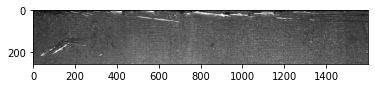

In [14]:
plt.imshow(img)

EncodedPixels : 이미지를 1차원으로 Flatten했을때 짝수 i 번째 값의 위치부터 i+1 값의 개수만큼 segment에 픽셀이 포함됨

In [15]:
h, w = img.shape[0], img.shape[1]
mask = np.zeros(w * h, dtype = np.uint32)

In [16]:
mask.shape

(409600,)

In [17]:
img_encoded_pixels = train_val[train_val['ImageId'] == img_id]['EncodedPixels']

In [18]:
img_encoded_pixels = list(map(int,img_encoded_pixels.values[0].split()))

In [19]:
mask_start = img_encoded_pixels[0::2]
mask_length = img_encoded_pixels[1::2]

In [20]:
len(mask_start), len(mask_length)

(1838, 1838)

In [21]:
# 마스크 영역의 픽셀값을 255로 채움
for s, l in zip(mask_start, mask_length):
  mask[s:s+l] = 255

In [22]:
mask_2 = mask.reshape((h, w), order = 'F')

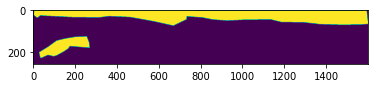

In [23]:
plt.imshow(mask_2)

In [24]:
index = train_val['ImageId'] == img_id

In [25]:
for idx, (image_id, class_id, pixels) in df[index].iterrows():
  pixels = pixels.split()
  pixels = np.array(pixels, dtype = int)
  #print(pixels)
  pixels = pixels.reshape(-1, 2)
  print(pixels)

[[  1037     12]
 [  1281     25]
 [  1537     25]
 ...
 [408866     32]
 [409131     23]
 [409396     14]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [26]:
def load(df, image_id):
  indexes = df['ImageId'] == image_id
  path = '/content/train_images/'
  image = plt.imread(path + image_id)
  h, w = image.shape[:2]
  mask = np.zeros(h * w)
  for idx, (image_id, class_id, pixels, train) in df[indexes].iterrows():
    pixels = pixels.split()
    pixels = np.array(pixels, dtype = int)
    pixels = pixels.reshape(-1, 2)

    for start, length in pixels:
      mask[start : start + length] = 255
    
    mask = mask.reshape((h, w), order = 'F')

  return image, mask

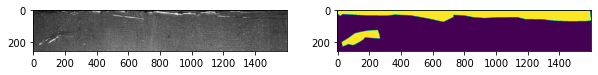

In [27]:
img, mask = load(train_val, img_id)
fig, axes = plt.subplots(1, 2, figsize = (10, 10))
axes[0].imshow(img)
axes[1].imshow(mask)
plt.show()

In [28]:
train_df.to_csv('train_df.csv', index = False)
val_df.to_csv('val_df.csv', index = False)

(-0.5, 1599.5, 255.5, -0.5)

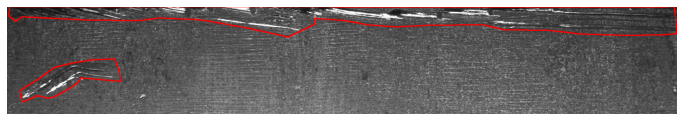

In [29]:
mask = np.array(mask, dtype = np.uint8)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
masked_image = cv2.drawContours(img, contours, -1, (255, 0, 0), 2, cv2.LINE_8, hierarchy, 100)
plt.figure(figsize = (12, 14))
plt.imshow(masked_image)
plt.axis('off')

(-0.5, 1599.5, 255.5, -0.5)

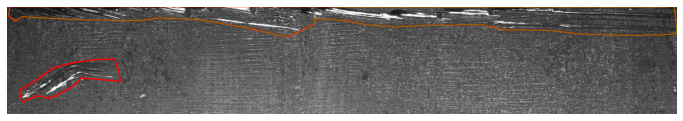

In [30]:
plt.figure(figsize = (12, 14))
plt.imshow(cv2.polylines(img, [np.squeeze(contours[1])], True, (0, 255, 0)))
plt.axis('off')

In [33]:
min(poly[:, 0]), min(poly[:, 1]), max(poly[:, 0]), max(poly[:, 1])

(29, 125, 270, 226)

In [38]:
import os.path as osp
import json
from tqdm.notebook import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder

# json을 coco json 형태로 변환
def convert_to_coco(ann_df, out_file, image_prefix):
  ''' ann_file은 via_region_data.json, out_file은 coco로 변환할 출력 json파일
      image_prefix는 image jpg가 있는 디렉토리 위치 
  '''

  # coco의 주요 key값인 annotations와 images를 담을 list 생성. 
  annotations = []
  images = []
  obj_count = 0

  le = LabelEncoder()
  image_id_encoded = le.fit_transform(ann_df.ImageId)
  ann_df['image_id_encoded'] = image_id_encoded

  img_id_list = ann_df['ImageId'].drop_duplicates().values
  for image_id in img_id_list:
    img_path = os.path.join(image_prefix, image_id)
    height, width = cv2.imread(img_path).shape[:2]
    img_id = int(le.transform([image_id])[0])
    
    images. append(dict(
        id = img_id,
        file_name = image_id,
        height = height,
        width = width
    ))

  for idx, (image_id, class_id, pixels, train, image_id_encoded) in ann_df.iterrows():

    pixels = pixels.split()
    pixels = np.array(pixels, dtype = int)
    pixels = pixels.reshape(-1, 2)

    img_path = os.path.join(image_prefix, image_id)
    height, width = cv2.imread(img_path).shape[:2]
    mask = np.zeros(height * width)

    for start, length in pixels:
      mask[start : start + length] = 255
    
    mask = mask.reshape((height, width), order = 'F')
    mask = np.array(mask, dtype = np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
      
      if len(contours[i]) > 2:
        poly = np.squeeze(contours[i])
        x_min, y_min, x_max, y_max = int(min(poly[:, 0])), int(min(poly[:, 1])), int(max(poly[:, 0])), int(max(poly[:, 1]))
        poly = list(poly.flatten())
        poly = [int(x) for x in poly]
        data_anno = dict(
              image_id = image_id_encoded,
              id=obj_count,
              category_id = class_id,
              bbox = [x_min, y_min, x_max - x_min, y_max - y_min],
              area = (x_max - x_min) * (y_max - y_min),
              segmentation = [poly],
              iscrowd = 0
          )
        annotations.append(data_anno)
        obj_count += 1

  # images와 annotations, categories를 Dict형태로 저장. 
  coco_format_json = dict(
      images = images,
      annotations = annotations,
      categories = [{'id':1, 'name':'1'},
                    {'id':2, 'name':'2'},
                    {'id':3, 'name':'3'},
                    {'id':4, 'name':'4'}]
  )
  
  # json 파일로 출력. 
  #mmcv.dump(coco_format_json, out_file)
  with open(out_file, 'w') as json_out_file:
    json.dump(coco_format_json, json_out_file)
    

In [54]:
!mkdir -p /content/data

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d /content/data

In [39]:
!sudo apt-get install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 2s (136 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize fron

In [40]:
convert_to_coco(train_df, '/content/train.json', '/content/train_images')

In [41]:
convert_to_coco(val_df, '/content/val.json', '/content/train_images')

In [42]:
!jq .  /content/train.json > output_train_coco.json

In [ ]:
!tail -1000 output_train_coco.json 

pycocotools를 이용하여 변환된 coco json의 segmentation 시각화
* coco format으로 잘 변환 되었는지 확인하기 위해 pycocotools로 특정 image id의 image filename 및 segmentation 정보를 추출하고 이를 시각화

In [44]:
from pycocotools.coco import COCO

coco = COCO('/content/train.json')

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [45]:
# category id와 image id 출력
catIds = coco.getCatIds(catNms = ['1'])
print(catIds)
#coco.getImgIds(catIds = catIds)는 해당 category id별로 한개의 iamge id를 임의로 출력
imgIds = coco.getImgIds(catIds = catIds)
print(imgIds)

[1]
[0, 5, 2058, 13, 17, 4114, 4115, 19, 2069, 2068, 2071, 24, 2067, 4122, 2076, 2077, 31, 2080, 2081, 32, 2091, 44, 2093, 4142, 4146, 4152, 58, 61, 2111, 68, 75, 4173, 2125, 2127, 2128, 82, 2130, 86, 2135, 4188, 96, 2147, 4198, 104, 4200, 4204, 108, 4209, 114, 2166, 2167, 4217, 125, 2178, 2185, 140, 4238, 143, 4242, 4250, 155, 154, 2203, 2206, 162, 2210, 166, 167, 2217, 173, 2225, 177, 2226, 178, 2234, 187, 197, 200, 2252, 2256, 2258, 2261, 4310, 4312, 217, 2266, 2268, 4316, 223, 2273, 4323, 4324, 229, 4325, 2278, 2282, 4330, 2283, 4333, 2286, 239, 4336, 4339, 243, 246, 2300, 253, 2301, 4351, 4352, 4353, 260, 4358, 2313, 4363, 269, 4366, 2334, 4383, 4385, 2343, 299, 300, 4401, 4407, 313, 315, 4411, 318, 4414, 4416, 319, 323, 2372, 2381, 2388, 4437, 343, 2392, 346, 4442, 4444, 349, 4446, 4445, 2402, 4451, 364, 2415, 369, 371, 2421, 2422, 4469, 4472, 377, 2426, 2434, 4484, 4485, 2445, 400, 4496, 402, 403, 4500, 4499, 4502, 407, 4503, 2453, 4507, 2462, 420, 2478, 2487, 440, 2491, 2497, 4

In [46]:
# image id 1번에 대한 image 정보와 해당 iamge의 object별 정보 추출.
img = coco.loadImgs(0)[0]
print(img)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=[1,2,3,4], iscrowd= False)
anns = coco.loadAnns(annIds)
print(anns)

{'id': 0, 'file_name': '0002cc93b.jpg', 'height': 256, 'width': 1600}
[{'image_id': 0, 'id': 11770, 'category_id': 1, 'bbox': [332, 193, 23, 62], 'area': 1426, 'segmentation': [[354, 193, 353, 194, 351, 194, 350, 195, 348, 195, 347, 196, 346, 196, 345, 197, 343, 197, 342, 198, 340, 198, 339, 199, 337, 199, 336, 200, 335, 200, 335, 209, 334, 210, 334, 227, 333, 228, 333, 246, 332, 247, 332, 255, 346, 255, 346, 249, 347, 248, 347, 235, 348, 234, 348, 227, 349, 226, 349, 225, 350, 224, 350, 223, 351, 222, 351, 221, 352, 220, 352, 208, 353, 207, 353, 202, 354, 201, 354, 196, 355, 195, 355, 193]], 'iscrowd': 0}, {'image_id': 0, 'id': 11771, 'category_id': 1, 'bbox': [113, 162, 14, 23], 'area': 322, 'segmentation': [[114, 162, 114, 173, 113, 174, 113, 185, 127, 185, 127, 163, 121, 163, 120, 162]], 'iscrowd': 0}, {'image_id': 0, 'id': 11772, 'category_id': 1, 'bbox': [304, 89, 27, 105], 'area': 2835, 'segmentation': [[321, 89, 320, 90, 317, 90, 316, 91, 314, 91, 313, 92, 310, 92, 309, 93, 306

In [47]:
anns = coco.loadAnns(annIds)
# segmentation 정보만 별도로 추출. 
ann_seg_list = [ann['segmentation'][0] for ann in anns]
print(ann_seg_list)

[[354, 193, 353, 194, 351, 194, 350, 195, 348, 195, 347, 196, 346, 196, 345, 197, 343, 197, 342, 198, 340, 198, 339, 199, 337, 199, 336, 200, 335, 200, 335, 209, 334, 210, 334, 227, 333, 228, 333, 246, 332, 247, 332, 255, 346, 255, 346, 249, 347, 248, 347, 235, 348, 234, 348, 227, 349, 226, 349, 225, 350, 224, 350, 223, 351, 222, 351, 221, 352, 220, 352, 208, 353, 207, 353, 202, 354, 201, 354, 196, 355, 195, 355, 193], [114, 162, 114, 173, 113, 174, 113, 185, 127, 185, 127, 163, 121, 163, 120, 162], [321, 89, 320, 90, 317, 90, 316, 91, 314, 91, 313, 92, 310, 92, 309, 93, 306, 93, 305, 94, 304, 94, 304, 120, 305, 121, 305, 148, 306, 149, 306, 152, 307, 153, 307, 156, 308, 157, 308, 160, 309, 161, 309, 164, 310, 165, 310, 168, 311, 169, 311, 172, 312, 173, 312, 176, 313, 177, 313, 180, 314, 181, 314, 184, 315, 185, 315, 188, 316, 189, 316, 192, 317, 193, 317, 194, 318, 194, 319, 193, 321, 193, 322, 192, 324, 192, 325, 191, 326, 191, 327, 190, 329, 190, 330, 189, 331, 189, 331, 182, 330, 

In [48]:
def get_polygon_xy(ann_seg):
  polygon_x = [x for index, x in enumerate(ann_seg) if index % 2 == 0]
  polygon_y = [x for index, x in enumerate(ann_seg) if index % 2 == 1]
  polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
  polygon_xy = np.array(polygon_xy, np.int32)
  return polygon_xy

def get_mask(image_array_shape, polygon_xy):
  mask = np.zeros(image_array_shape)
  masked_polygon = cv2.fillPoly(mask, [polygon_xy], 1)
  
  return masked_polygon

def apply_mask(image, mask, color, alpha=0.5):
  for c in range(3):
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image

# ann_seg_list에 있는 object들의 segmentation에 따라 instance segmentation 시각화. 
def draw_segment(image_array, ann_seg_list, color_list, alpha):
  draw_image = image_array.copy()
  mask_array_shape = draw_image.shape[0:2]

  # list형태로 입력된 segmentation 정보들을 각각 시각화
  for index, ann_seg in enumerate(ann_seg_list):
    # polygon 좌표로 변환. 
    polygon_xy = get_polygon_xy(ann_seg)
    # mask 정보 변환
    masked_polygon = get_mask(mask_array_shape, polygon_xy)

    # segmentation color와 외곽선용 color 선택 
    color_object = color_list[np.random.randint(len(color_list))]
    color_contour = color_list[np.random.randint(len(color_list))]
    # masking 적용. 
    masked_image = apply_mask(draw_image, masked_polygon, color_object, alpha=0.6)
    # 외곽선 적용. 
    s_mask_int = (masked_polygon*255).astype("uint8")
    contours, hierarchy = cv2.findContours(s_mask_int, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    masked_image = cv2.drawContours(masked_image, contours, -1, color_contour, 1, cv2.LINE_8, hierarchy, 100)

  return masked_image

(-0.5, 1599.5, 255.5, -0.5)

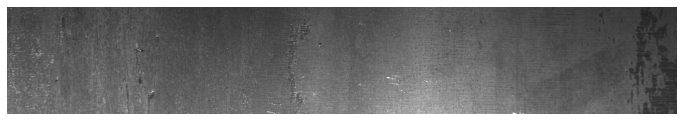

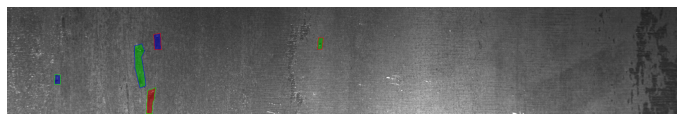

In [49]:
import matplotlib.pyplot as plt
import cv2

color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]

# 원본 이미지 시각화 
image_array = cv2.cvtColor(cv2.imread(os.path.join('/content/train_images', img['file_name'])), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 14))
plt.imshow(image_array)
plt.axis('off')

# coco segmentation 정보를 기반으로 segmentation 적용한 이미지 시각화 
masked_image = draw_segment(image_array, ann_seg_list, color_list, alpha=0.6)
plt.figure(figsize=(12, 14))
plt.imshow(masked_image)
plt.axis('off')

Pretrained 모델 다운로드, Config 설정

In [50]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬
%cd mmdetection
!mkdir checkpoints

/content/mmdetection


In [51]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2022-01-28 18:48:01--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  7.24MB/s    in 35s     

2022-01-28 18:48:37 (6.90 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [52]:
!ls -lia /content/mmdetection/checkpoints

total 248144
5377603 drwxr-xr-x  2 root root      4096 Jan 28 18:48 .
5373953 drwxr-xr-x 19 root root      4096 Jan 28 18:47 ..
5377608 -rw-r--r--  1 root root 254089599 Nov  2 16:37 mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


In [53]:
# config 파일 설정, 다운로드 받은 pretrained 모델을 checkpoint로 설정.
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [54]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force = True)
class SteelDataset(CocoDataset):
  CLASSES = ('1', '2', '3', '4')

In [55]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [68]:
import shutil
val_imgs = val_df.ImageId.drop_duplicates().values
for fname in val_imgs:
  src = os.path.join('/content/train_images', fname)
  dst = os.path.join('/content/val_images', fname)
  shutil.copyfile(src, dst)

In [70]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정
cfg.dataset_type = 'SteelDataset'
cfg.data_root = '/content/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'SteelDataset'
cfg.data.train.data_root = '/content/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'train_images'

cfg.data.val.type = 'SteelDataset'
cfg.data.val.data_root = '/content/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'val_images'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
cfg.model.roi_head.mask_head.num_classes = 4

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = '/content/drive/MyDrive/Steel_detect_save'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# epochs 횟수는 36으로 증가 
cfg.runner.max_epochs = 36

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [ ]:
print(cfg.pretty_text)

# 학습수행

In [72]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train 용 Dataset 생성.
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


In [74]:
datasets[0]


SteelDataset Train dataset with number of images 5413, and instance counts: 
+----------+-------+----------+-------+----------+-------+----------+-------+---------------+-------+
| category | count | category | count | category | count | category | count | category      | count |
+----------+-------+----------+-------+----------+-------+----------+-------+---------------+-------+
| 0 [1]    | 2520  | 1 [2]    | 251   | 2 [3]    | 11844 | 3 [4]    | 1632  | -1 background | 0     |
+----------+-------+----------+-------+----------+-------+----------+-------+---------------+-------+

In [76]:
model = build_detector(cfg.model, train_cfg = cfg.get('train_cfg'), test_cfg = cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('1', '2', '3', '4')


In [ ]:
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed = False, validate = True)